Configurando ambiente virtual `conda` e corrigindo `bug` do `hvplot` no Google Colab.

In [1]:
if 'google.colab' in str(get_ipython()):
    try:
        import condacolab
    except:
        !pip install -q condacolab
        import condacolab
        condacolab.install()
        !git clone https://github.com/iuryt/Panthalassan
        !conda env update -n base -f /content/Panthalassan/environment.yml

Todo programa em Python começa com a definição dos módulos que serão usados.

A sintaxe é geralmente 
```Python
import <nome do pacote> as <apelido>
```

O apelido é o nome que iremos usar para chamar o pacote dentro do programa.
Ele costuma ser sugerido pela documentação do próprio pacote, apesar de ser escolha do programador.

Os pacotes que serão usados nesse programa são:
   - [numpy](https://numpy.org/doc/stable/) é usado para se trabalhar com matrizes.
   - [xarray](http://xarray.pydata.org/en/stable/getting-started-guide/quick-overview.html) é usado para dados multidimensionais.
   - [matplotlib](https://matplotlib.org/stable/tutorials/introductory/pyplot.html) é usado para criar gráficos estáticos.
   - [hvplot](https://hvplot.holoviz.org/) é usado para criar gráficos interativos.
   - [gdown](https://github.com/wkentaro/gdown) é usado para baixar arquivos do Google Drive.
   - [cartopy](https://scitools.org.uk/cartopy/docs/latest/) é usado para criar mapas.
   - glob já vem com o Python e é usado para listar arquivos nas pastas.
   
   
obs: Vocês podem ignorar o código que está contornado por `#`. Ele apenas serve para corrigir um bug do hvplot ao rodar no Google Colab.

In [25]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import hvplot.xarray
import pandas as pd
import gdown
import cartopy.crs as ccrs # sistema de coordenadas
import cartopy.feature as cfeature # continentes e outras feições
from datetime import datetime,timedelta
from glob import glob

#################################################
import holoviews as hv
def _render(self, **kw):
    hv.extension('bokeh')
    return hv.Store.render(self)
hv.core.Dimensioned._repr_mimebundle_ = _render
#################################################

In [4]:
fid = '1BQWvrhpxVp0BxdhgC2KOTuAfw-If1VF4'

gdown.download(f"https://drive.google.com/uc?id={fid}", quiet=False) 

Downloading...
From: https://drive.google.com/uc?id=1BQWvrhpxVp0BxdhgC2KOTuAfw-If1VF4
To: /project/umd_amit_tandon/iury/research/projects/Panthalassan/notebooks/OQ2_Dados_CTD.xlsx
100%|██████████| 33.4k/33.4k [00:00<00:00, 2.14MB/s]


'OQ2_Dados_CTD.xlsx'

In [21]:
ctd = pd.read_excel('OQ2_Dados_CTD.xlsx')
horario = ctd[['Perfil','Horário']].dropna().set_index('Perfil')['Horário']
horario = horario.apply(lambda s: datetime.strptime(str(s), '%H:%M:%S')).to_xarray()

ctd['Perfil'] = ctd['Perfil'].ffill()
ctd = ctd.drop('Horário',axis='columns')

ctd = ctd.set_index(['Perfil','Profundidade(m)']).to_xarray()
ctd = ctd.assign_coords({horario.name:horario})
ctd

<xarray.Dataset>
Dimensions:              (Perfil: 9, Profundidade(m): 65)
Coordinates:
  * Perfil               (Perfil) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0
  * Profundidade(m)      (Profundidade(m)) float64 0.3 0.4 0.5 ... 6.5 6.6 6.7
    Horário              (Perfil) datetime64[ns] 1900-01-01T06:30:00 ... 1900...
Data variables:
    Temperatura(°C)      (Perfil, Profundidade(m)) float64 25.86 25.87 ... nan
    Salinidade           (Perfil, Profundidade(m)) float64 32.75 32.76 ... nan
    Clorofila-a(μg L-1)  (Perfil, Profundidade(m)) float64 4.58 4.66 ... nan nan
    Turbidez(mg L-1)     (Perfil, Profundidade(m)) float64 3.7 3.774 ... nan nan
    OD(mg L-1)           (Perfil, Profundidade(m)) float64 5.887 5.794 ... nan

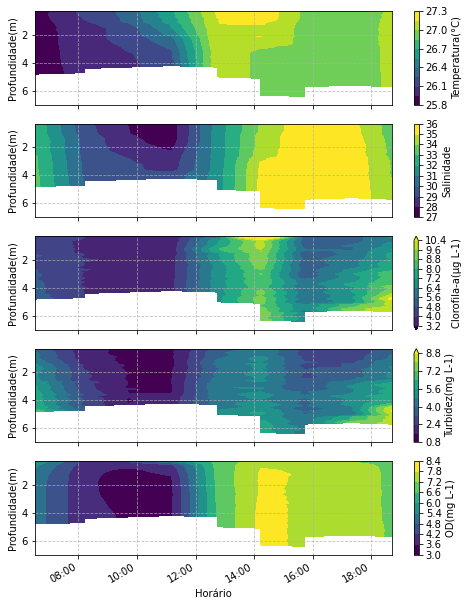

In [49]:
data_vars = list(ctd.data_vars)

fig,ax = plt.subplots(len(data_vars),1,figsize=(8,10))
myFmt = mdates.DateFormatter('%H:%M')

for a,var in zip(ax,data_vars):
    ctd[var].plot.contourf(x='Horário',levels=10,ax=a,ylim=[7,0.3],robust=True)
    a.xaxis.set_major_formatter(myFmt)
    a.grid(True,linestyle='--',alpha=0.8)
    
_ = [a.set(xticklabels=[],xlabel='') for a in ax[:-1]]
